In [95]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import cv2

In [96]:
def create_LoG_kernel(kernel_size, sigma):
    """
    Create a Laplacian of Gaussian (LoG) kernel.

    Equation:
        LoG(x, y) = (1 / (pi * sigma^4)) * (1 - ((x^2 + y^2) / (2 * σ^2))) * exp(-(x² + y²) / (2σ²))

    Parameters:
        kernel_size (int): Size of the kernel (must be an odd number).
        sigma (float): Standard deviation of the Gaussian.

    Returns:
        numpy.ndarray: LoG kernel.
    """
    # Create coordinate grid centered at 0
    ax = np.arange(-(kernel_size // 2), kernel_size // 2 + 1)
    xx, yy = np.meshgrid(ax, ax)
    norm2 = xx**2 + yy**2

    # Compute the LoG function
    factor = 1 / (np.pi * sigma**4)
    kernel = factor * (1 - norm2 / (2 * sigma**2)) * np.exp(-norm2 / (2 * sigma**2))

    # Normalize kernel to ensure zero-sum (optional but often useful)
    #kernel_mean = kernel.mean()
    #kernel = kernel - kernel_mean

    return kernel

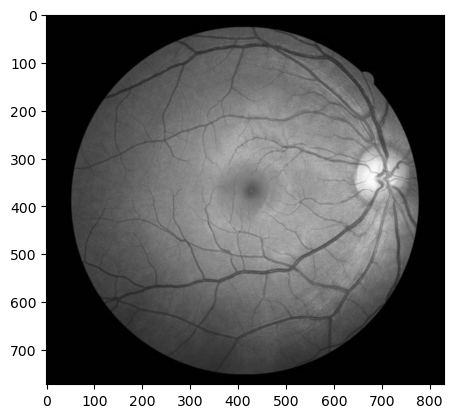

Max Intensity:  1.0
Min Intensity:  0.0


In [97]:
# Load the retinal fundus image in grayscale
image_path = 'Fundus.jpeg'  # Replace with your image path
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
if img is None:
    raise IOError("Image not found. Check the image path.")

# Normalize image intensity
img = img.astype(np.float64) / np.max(img)
plt.imshow(img, cmap='gray')
plt.show()
print("Max Intensity: ",np.max(img))
print("Min Intensity: ",np.min(img))

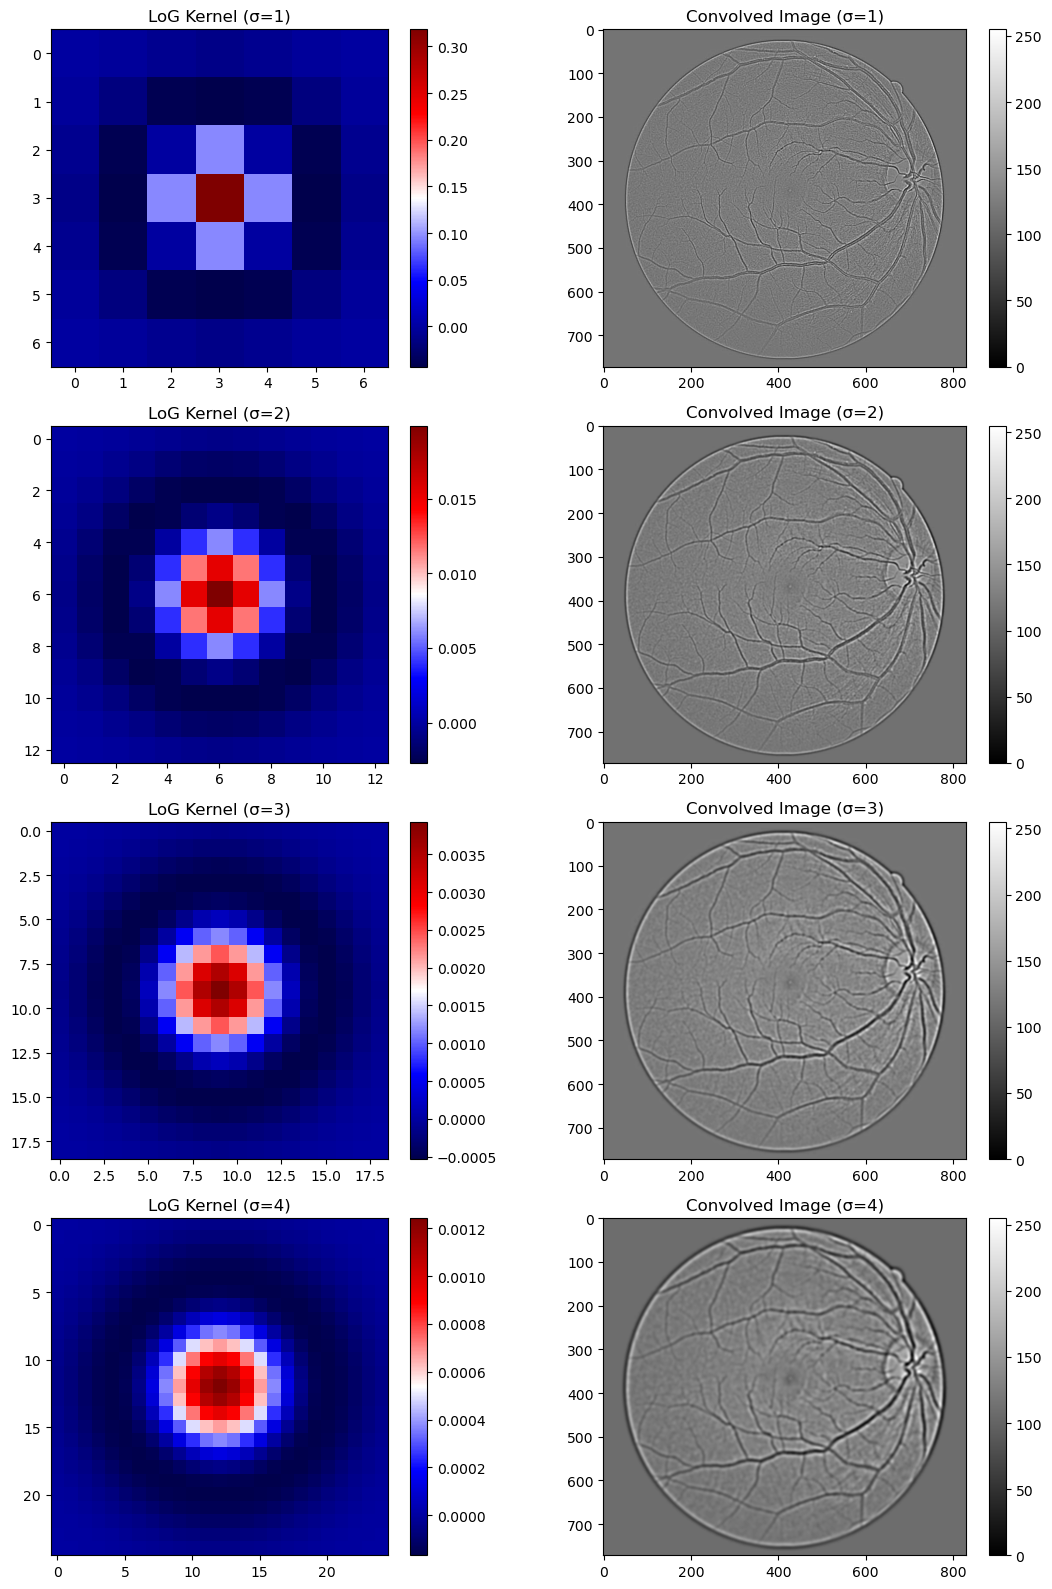

In [98]:
# Define a set of σ values for multiscale analysis
sigmas_LoG = [1, 2, 3, 4]
results_LoG = []  # to store kernels and convolved images for each σ

for sigma in sigmas_LoG:
    # Determine appropriate kernel size: typically ~6σ+1 to cover most of the Gaussian
    kernel_size = int(np.ceil((6 * sigma) + 1))
    # Create LoG kernel for current σ
    kernel_LoG = create_LoG_kernel(kernel_size, sigma)

    # Convolve image with the LoG kernel
    convolved_LoG = signal.convolve2d(img, kernel_LoG, boundary='symm', mode='same')
    convolved_LoG = convolved_LoG - np.min(convolved_LoG)
    convolved_LoG = convolved_LoG * (255 / np.max(convolved_LoG))
    # Store results for visualization
    results_LoG.append((sigma, kernel_LoG, convolved_LoG))

# Plotting kernels and convolved results
num_scales = len(sigmas_LoG)
fig, axes = plt.subplots(num_scales, 2, figsize=(12, 4 * num_scales))

for i, (sigma, kernel_LoG, convolved_LoG) in enumerate(results_LoG):
    # Display LoG kernel
    ax_kernel = axes[i, 0]
    ax_kernel.set_title(f'LoG Kernel (σ={sigma})')
    im1 = ax_kernel.imshow(kernel_LoG, cmap='seismic')
    fig.colorbar(im1, ax=ax_kernel, fraction=0.046, pad=0.04)

    # Display convolved image
    ax_conv = axes[i, 1]
    ax_conv.set_title(f'Convolved Image (σ={sigma})')
    im2 = ax_conv.imshow(convolved_LoG, cmap='gray')
    fig.colorbar(im2, ax=ax_conv, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

In [99]:
def create_Gaussian_kernel(kernel_size, sigma):
    """
    Create a 2D Gaussian kernel.

    Equation:
        G(x, y) = (1 / (2πσ²)) * exp(-(x² + y²) / (2σ²))

    Parameters:
        kernel_size (int): Size of the kernel (must be an odd number).
        sigma (float): Standard deviation of the Gaussian.

    Returns:
        numpy.ndarray: Gaussian kernel.
    """
    # Create coordinate grid centered at 0
    ax = np.arange(-(kernel_size // 2), kernel_size // 2 + 1)
    xx, yy = np.meshgrid(ax, ax)
    norm2 = xx ** 2 + yy ** 2

    # Compute the Gaussian function
    factor = 1 / (2 * np.pi * sigma ** 2)
    kernel = factor * np.exp(-norm2 / (2 * sigma ** 2))

    return kernel


def create_DoG_kernel(kernel_size, sigma1, sigma2):
    """
    Create a Difference of Gaussians (DoG) kernel.

    Equation:
        DoG(x, y) = G(x, y; σ₁) - G(x, y; σ₂)

    Parameters:
        kernel_size (int): Size of the kernel (must be an odd number).
        sigma1 (float): Standard deviation of the first Gaussian.
        sigma2 (float): Standard deviation of the second Gaussian.

    Returns:
        numpy.ndarray: DoG kernel.
    """
    g1 = create_Gaussian_kernel(kernel_size, sigma1)
    g2 = create_Gaussian_kernel(kernel_size, sigma2)
    kernel = g1 - g2
    return kernel

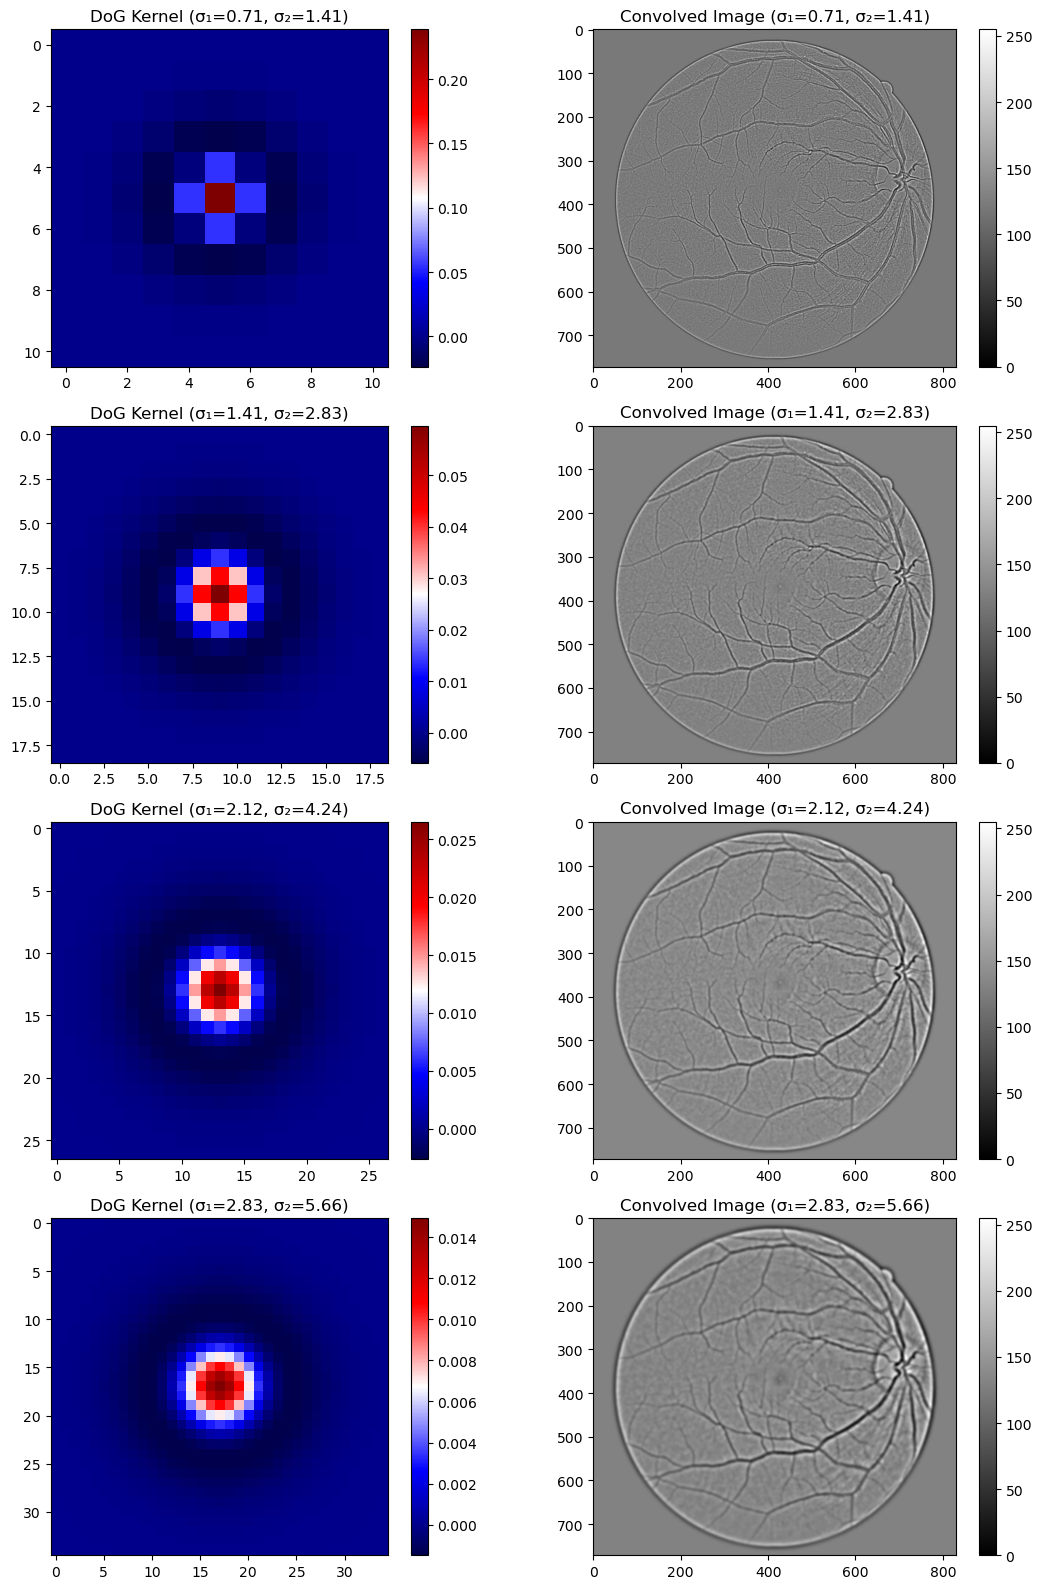

In [100]:
# Define a set of base σ values for multiscale analysis
# For each base sigma, we'll define sigma1 = sigma and sigma2 = k * sigma
sigmas_DoG = [1, 2, 3, 4]
results_DoG = []  # store sigma, kernels, and convolved images

for sigma in sigmas_DoG:
    sigma1 = sigma / np.sqrt(2)
    sigma2 = sigma * np.sqrt(2)
    # Determine an appropriate kernel size based on the larger sigma
    kernel_size = int(np.ceil((6 * sigma2) + 1))  # ensure kernel_size is odd

    # Create DoG kernel for the current pair of σ values
    kernel_DoG = create_DoG_kernel(kernel_size, sigma1, sigma2)

    # Convolve image with the DoG kernel
    convolved_DoG = signal.convolve2d(img, kernel_DoG, boundary='symm', mode='same')

    # Normalize the convolved result for visualization
    convolved_DoG = convolved_DoG - np.min(convolved_DoG)
    convolved_DoG = convolved_DoG * (255 / np.max(convolved_DoG))

    # Store results for visualization
    results_DoG.append((sigma, sigma1, sigma2, kernel_DoG, convolved_DoG))

# Plotting DoG kernels and convolved results
num_scales = len(sigmas_DoG)
fig, axes = plt.subplots(num_scales, 2, figsize=(12, 4 * num_scales))

for i, (sigma, sigma1, sigma2, kernel_DoG, convolved_DoG) in enumerate(results_DoG):
    # Display DoG kernel
    ax_kernel = axes[i, 0]
    ax_kernel.set_title(f'DoG Kernel (σ₁={round(sigma1,2)}, σ₂={round(sigma2,2)})')
    im1 = ax_kernel.imshow(kernel_DoG, cmap='seismic')
    fig.colorbar(im1, ax=ax_kernel, fraction=0.046, pad=0.04)

    # Display convolved image
    ax_conv = axes[i, 1]
    ax_conv.set_title(f'Convolved Image (σ₁={round(sigma1,2)}, σ₂={round(sigma2,2)})')
    im2 = ax_conv.imshow(convolved_DoG, cmap='gray')
    fig.colorbar(im2, ax=ax_conv, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()
